# Advection equation

Given the advection equation in 1D $\frac{\delta u}{\delta t} + \frac{\delta u}{\delta t} = 0$ build a numerical code to solve it on a grid with extent $x \in [0, 10]$ and with initial conditions given by

$$u(x, t=0) = exp[-(x-x_0)^2], $$

with $x_0 = 5$. Solve the equation using the following schemes:

1. FTCS
2. Lax-Friedrichs
3. Leapfrog
4. Lax-Wendroff

Use Courant factor $c_f = 0.5$ and compare the results obtained with the different methods, paying attention to their stability and dissipation properties. Plot $u(x, t)$ at different times (including $t = 0$ and $t = 20$) and the evolution of the L2-norm of $u(x, t)$. Use at least $J = 101$
points in the $x$ direction, so that the spacing $∆x$ is at least $0.1 = \frac{10}{(J − 1)}$, and terminate your simulation at $t = 20$. Use periodic boundary conditions. Modify the number of points and/or the Courant factor cf to check how your results change.

In [377]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
from IPython.display import HTML
import matplotlib.image as mpimg
from matplotlib.image import imread

In [378]:
plt.rcParams.update({
    "text.usetex": True,            # Use LaTeX for text rendering
    "font.family": "serif",         # Use serif fonts (LaTeX default)
    "font.serif": ["Computer Modern Roman"],  # Default LaTeX font
})

In [379]:
# Vary the number of grid points between [101, 251, 501]
# Vary the Courant factor between [0.25, 0.5, 0.8]

In [380]:
#define the speed a
a=1.0

# Define the domain
L = 10.0     # Domain length
nx = 501    # Number of grid points
dx = L/(nx-1)   # Grid spacing
x = np.linspace(0, L, nx)

# Define the time step and the final time
cf = 0.8
#dt = cf*dx/a   # Time step
dt = round(cf*dx/a, 10)
t_final = 20.0
nt = t_final/dt    # Number of iterations

print('nx=',nx)
print('dx=',dx)
print('dt=',dt)
print('Number of iterations=', nt)

nx= 501
dx= 0.02
dt= 0.016
Number of iterations= 1250.0


In [381]:
# I don't want to save a snapshot every 10 iterations, otherwise they would become too many for certain values of cf and nx.
# Instead, I want to save 40 snapshots for cf = 0.25 and 0.5, and 25 snapshots for cf = 0.8 (40 wouldn't give me an integer number
# of iterations).
# Also, I want to save 6 evenly spaced snapshots (t = 0.0, 4.0, 8.0, 12.0, 16.0, 20.0) for a grid to put in the reports, if those indices
# are not included already.

if (cf == 0.25 or cf == 0.5): snap_indices = np.linspace(0, nt, 40, dtype=int)
if (cf == 0.8): snap_indices = np.linspace(0, nt, 25, dtype=int)
indices_6 = np.linspace(0, nt, 6, dtype=int)     # For the grid

combined = np.concatenate([snap_indices, indices_6])

# Remove duplicates and sort
combined = np.unique(combined)
combined

array([   0,   52,  104,  156,  208,  250,  260,  312,  364,  416,  468,
        500,  520,  572,  625,  677,  729,  750,  781,  833,  885,  937,
        989, 1000, 1041, 1093, 1145, 1197, 1250])

In [382]:
# Define the initial condition
x0=5
u_initial = np.exp(-(x-x0)**2)

## FTCS

In [383]:
# Initialize the solution array
u_current = u_initial.copy()

#we create arrays where we will store the time and the l2norm
l2norm_FTCS=[]
l2norm_FTCS.append(np.sqrt(np.sum(u_current**2)/len(u_current)))

time=[]
time.append(0.0)

In [384]:
# Create directory to save images if there isn't one yet
print(os.getcwd())
if not os.path.exists('./images_FTCS'):
    os.makedirs('./images_FTCS')
os.listdir('./')

C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation


['.ipynb_checkpoints',
 'Advection equation.ipynb',
 'Advection_equation_movies',
 'images_FTCS',
 'images_LaxF',
 'images_Leap',
 'images_Leap_ex',
 'images_Leap_LF',
 'images_LW']

In [385]:
# I want to plot the analytic solution, too --> I need to implement periodic conditions for the Gaussian.
# Some tries to understand the modulus
# print((9-1)%10)     # --> 8
# print((1-9)%10)     # --> 2
# Makes sense: N =  Q *  D + R
#             -8 = -1 * 10 + 2
# print((9.8-9.9)%10)     # --> 9.9
# -0.1 = -1*10 + 9.9
# Makes sense again.

In [386]:
# Initialize time and iteration counter
t = 0.0
i = 0

#save the initial conditions
# Note: I'm plotting things with a very big fontsize for better visibility in the report
plt.plot(x, u_current, c = 'darkturquoise', label='FTCS')
plt.plot(x, u_initial, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
plt.title('Time = '+str(round(t,2)), fontsize = 24)
plt.ylim(0,1.1)
plt.xlabel('x', fontsize = 22)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')

# To save the figure with the courant factor, the number of points on the x axis and the timestamp info
c_str = f"{int(cf * 100):03d}"
n_str = f"{nx:03d}"
i_str = f"{i:05d}"
figname = f"./images_FTCS/fig_FTCS_c{c_str}_n{n_str}_t{i_str}.png"

plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.close()

#solve the advection equation
while t < t_final:
    # Compute the new solution using the FTCS method
    # Note: np.roll(u_current, -1) is equivalent to u(j+1) and
    #       np.roll(u_current,  1) is equivalent to u(j-1)
    # using np.roll is equivalent to use periodic boundary conditions
    u_next = u_current - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    
    # Update the solution
    u_current = u_next.copy()

    #advance the time 
    t += dt
    i += 1
    
    #compute the l2 norm and add the time to the time vector
    l2norm_FTCS.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
    time.append(t)
    
    #plot the current result and save in an image one every 10 iterations

    if i in combined:
    
        x_shift = (x - a*t) % L
        u_analytic = np.exp(-(x_shift - x0)**2)
    
        plt.plot(x, u_current, c='darkturquoise', label='FTCS')
        plt.plot(x, u_analytic, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
        plt.title('Time = '+str(round(t,2)), fontsize = 24)
        plt.ylim(0,1.1)
        plt.xlabel('x', fontsize = 22)
        plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.grid(alpha = 0.2, c = 'grey')
        plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
        i_str = f"{i:05d}"
        figname = f"./images_FTCS/fig_FTCS_c{c_str}_n{n_str}_t{i_str}.png"
        plt.savefig(figname, dpi=200, bbox_inches='tight')
        plt.close()

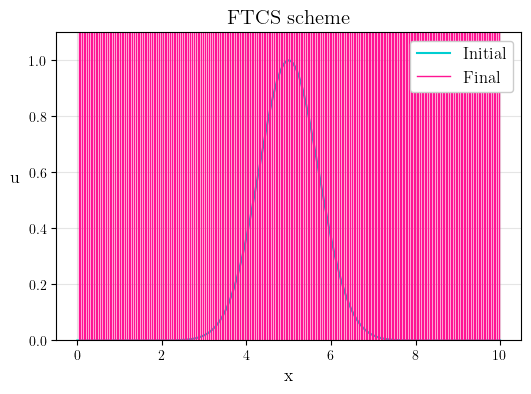

In [387]:
# Plot the final solution
plt.figure(figsize=(6, 4))
plt.plot(x, u_initial, label='Initial', c = 'darkturquoise')
plt.plot(x, u_current, label='Final', c = 'deeppink', lw = 1)
plt.title('FTCS scheme', fontsize = 15)
#plt.title('Time='+str(round(t,2)), fontsize = 15)
plt.ylim(0,1.1)
plt.xlabel('x', fontsize = 13)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 13)
plt.legend(fontsize = 12, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')
plt.show()

In [388]:
# Check your current working directory
print(os.getcwd())

# Set the directory where the images are stored
directory = "./images_FTCS/"

files = os.listdir(directory)
files = sorted(files)
print("\nSorted files:", files)

'''
# Create the movie
with imageio.get_writer('./movie_FTCS.mp4', mode='I', quality=10) as writer:
    for file in files:
        image = imageio.imread(os.path.join(directory, file))
        writer.append_data(image)
'''

output_dir = "./Advection_equation_movies/"
os.makedirs(output_dir, exist_ok=True)  # Create if it doesn't exist

c_filter = int(cf*100)
n_filter = nx 

files = sorted(f for f in os.listdir(directory) if f.endswith('.png'))

# Filter files based on Courant factor and number of points
filtered_files = [
    f for f in files
    if f.startswith(f"fig_FTCS_c{c_filter:03d}_n{n_filter:03d}_")
]

movie_title = os.path.join(output_dir, f"movie_FTCS_c{c_filter:03d}_n{n_filter:03d}.mp4")

# Create the movie
with imageio.get_writer(movie_title, mode='I', quality=10) as writer:
    for file in filtered_files:
        image = imageio.imread(os.path.join(directory, file))
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1160, 975) to (1168, 976) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation

Sorted files: ['.ipynb_checkpoints', 'L2norm_FTCS_c025_n101.png', 'L2norm_FTCS_c025_n251.png', 'L2norm_FTCS_c025_n501.png', 'L2norm_FTCS_c050_n101.png', 'L2norm_FTCS_c050_n251.png', 'L2norm_FTCS_c050_n501.png', 'L2norm_FTCS_c080_n101.png', 'L2norm_FTCS_c080_n251.png', 'L2norm_FTCS_c080_n501.png', 'fig_FTCS_c025_n101_t00000.png', 'fig_FTCS_c025_n101_t00020.png', 'fig_FTCS_c025_n101_t00041.png', 'fig_FTCS_c025_n101_t00061.png', 'fig_FTCS_c025_n101_t00082.png', 'fig_FTCS_c025_n101_t00102.png', 'fig_FTCS_c025_n101_t00123.png', 'fig_FTCS_c025_n101_t00143.png', 'fig_FTCS_c025_n101_t00160.png', 'fig_FTCS_c025_n101_t00164.png', 'fig_FTCS_c025_n101_t00184.png', 'fig_FTCS_c025_n101_t00205.png', 'fig_FTCS_c025_n101_t00225.png', 'fig_FTCS_c025_n101_t00246.png', 'fig_FTCS_c025_n101_t00266.png', 'fig_FTCS_c025_n101_t00287.png', 'fig_FTCS_c025_n101_t00307.png', 'fig_FTCS_c025_n101_t00320.png', 'fig_FTCS_c025_n101_t00328.png', 'fi

In [389]:
# Displaying the movie
'''
HTML("""
<div align="middle">
<video width="50%" controls>
      <source src="./movie_FTCS.mp4" type="video/mp4">
</video></div>""")
'''

HTML(f"""
<div align="middle">
  <video width="50%" controls>
    <source src="{movie_title}" type="video/mp4">
  </video>
</div>
""")

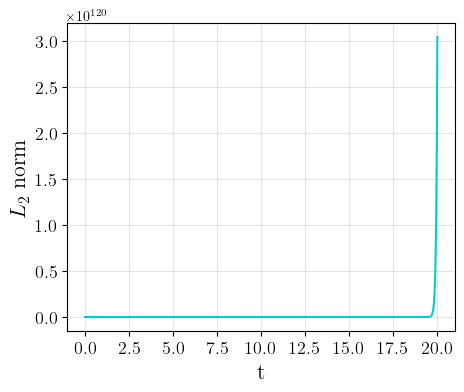

In [390]:
# Plot and save the l2 norm
plt.figure(figsize=(5, 4))
plt.plot(time, l2norm_FTCS, c = 'darkturquoise')
#plt.title('$L_2$ norm - FTCS ($C_f$ = %.2f, N = %i)' % (cf, nx), fontsize = 17)
plt.xlabel('t', fontsize = 16)
plt.ylabel('$L_2$ norm', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(alpha = 0.2, c = 'grey')
figname = f"./images_FTCS/L2norm_FTCS_c{c_str}_n{n_str}.png"
plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.show()

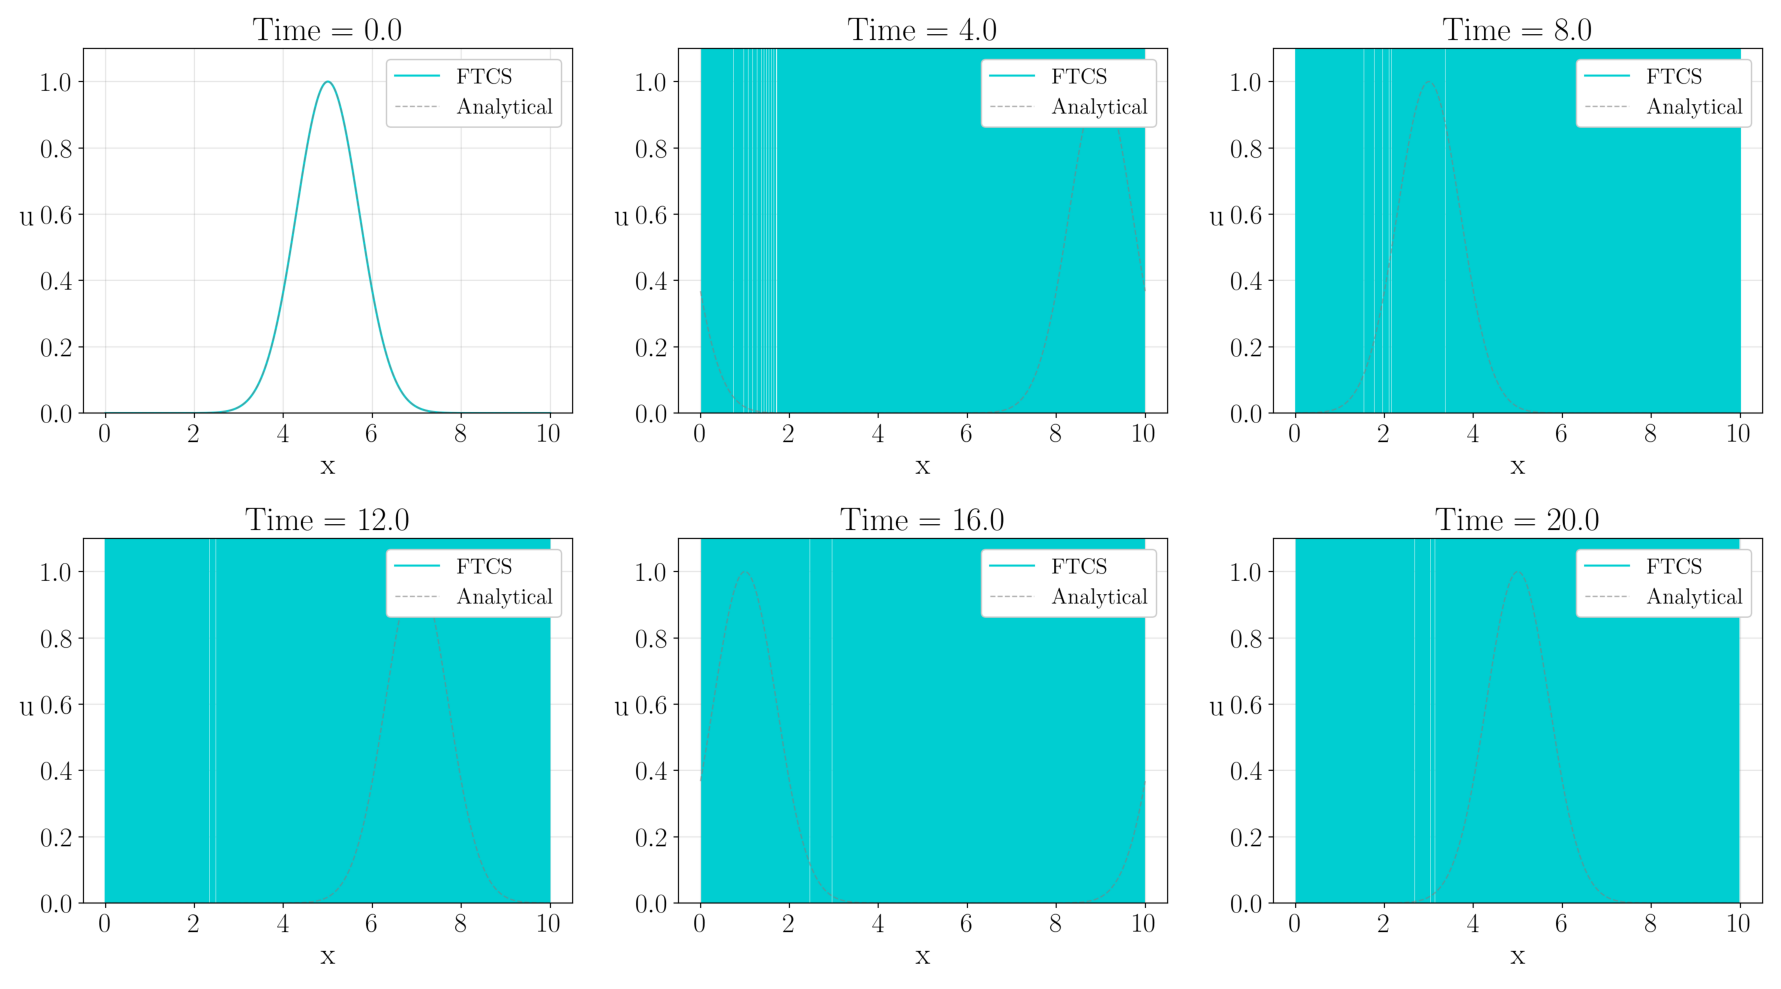

In [391]:
# FOR THE REPORT
filenames = [
    f"./images_FTCS/fig_FTCS_c{c_str}_n{n_str}_t{idx:05d}.png"
    for idx in indices_6
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, fname, idx in zip(axes.flat, filenames, indices_6):
    img = imread(fname)
    ax.imshow(img)
    ax.set_axis_off()

plt.tight_layout()

grid_name = f"./images_FTCS/grid_FTCS_c{c_str}_n{n_str}.png"
plt.savefig(grid_name, dpi=200, bbox_inches='tight')
plt.show()
plt.close()


## Lax-Friedrichs

In [392]:
# Initialize the solution array
u_current = u_initial.copy()

#we create arrays where we will store the time and the l2norm
l2norm_LaxF=[]
l2norm_LaxF.append(np.sqrt(np.sum(u_current**2)/len(u_current)))

time=[]
time.append(0.0)

In [393]:
# Create directory to save images IF there isn't one yet
print(os.getcwd())
if not os.path.exists('./images_LaxF'):
    os.makedirs('./images_LaxF')
os.listdir('./')

C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation


['.ipynb_checkpoints',
 'Advection equation.ipynb',
 'Advection_equation_movies',
 'images_FTCS',
 'images_LaxF',
 'images_Leap',
 'images_Leap_ex',
 'images_Leap_LF',
 'images_LW']

In [394]:
# Initialize time and iteration counter
t = 0.0
i = 0

#save the initial conditions
# Note: I'm plotting things with a very big fontsize for better visibility in the report
plt.plot(x, u_current, c = 'deeppink', label='LF')
plt.plot(x, u_initial, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
plt.title('Time = '+str(round(t,2)), fontsize = 24)
plt.ylim(0,1.1)
plt.xlabel('x', fontsize = 22)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')

# To save the figure with the courant factor, the number of points on the x axis and the timestamp info
c_str = f"{int(cf * 100):03d}"
n_str = f"{nx:03d}"
i_str = f"{i:05d}"
figname = f"./images_LaxF/fig_LaxF_c{c_str}_n{n_str}_t{i_str}.png"

plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.close()

#solve the advection equation
while t < t_final:
    # Compute the new solution using the Lax-Friedrichs method
    u_next = 0.5*(np.roll(u_current, -1) + np.roll(u_current, 1)) - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    
    # Update the solution
    u_current = u_next.copy()

    #advance the time 
    t += dt
    i += 1
    
    #compute the l2 norm and add the time to the time vector
    l2norm_LaxF.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
    time.append(t)
    
    #plot the current result and save in an image every 10 iterations
    if i in combined:

        x_shift = (x - a*t) % L
        u_analytic = np.exp(-(x_shift - x0)**2)
    
        plt.plot(x, u_current, c='deeppink', label='LF')
        plt.plot(x, u_analytic, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
        plt.title('Time = '+str(round(t,2)), fontsize = 24)
        plt.ylim(0,1.1)
        plt.xlabel('x', fontsize = 22)
        plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.grid(alpha = 0.2, c = 'grey')
        plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
        i_str = f"{i:05d}"
        figname = f"./images_LaxF/fig_LaxF_c{c_str}_n{n_str}_t{i_str}.png"
        plt.savefig(figname, dpi=200, bbox_inches='tight')
        plt.close()

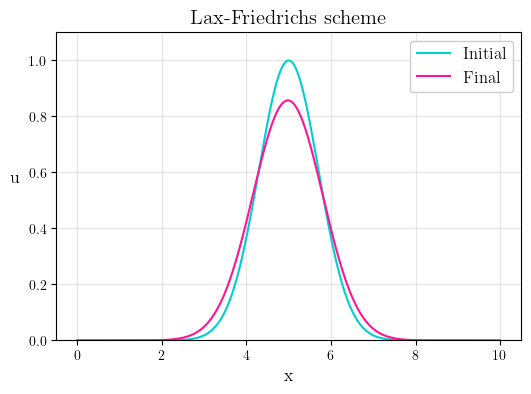

In [395]:
# Plot the final solution
plt.figure(figsize=(6, 4))
plt.plot(x, u_initial, label='Initial', c = 'darkturquoise')
plt.plot(x, u_current, label='Final', c = 'deeppink')
plt.title('Lax-Friedrichs scheme', fontsize = 15)
plt.ylim(0,1.1)
plt.xlabel('x', fontsize = 13)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 13)
plt.legend(fontsize = 12, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')
plt.show()

In [396]:
# Check your current working directory
print(os.getcwd())

# Set the directory where the images are stored
directory = "./images_LaxF/"

files = os.listdir(directory)
files = sorted(files)
print("\nSorted files:", files)

output_dir = "./Advection_equation_movies/"
os.makedirs(output_dir, exist_ok=True)  # Create if it doesn't exist

c_filter = int(cf*100)
n_filter = nx 

files = sorted(f for f in os.listdir(directory) if f.endswith('.png'))

# Filter files based on Courant factor and number of points
filtered_files = [
    f for f in files
    if f.startswith(f"fig_LaxF_c{c_filter:03d}_n{n_filter:03d}_")
]

movie_title = os.path.join(output_dir, f"movie_LaxF_c{c_filter:03d}_n{n_filter:03d}.mp4")

# Create the movie
with imageio.get_writer(movie_title, mode='I', quality=10) as writer:
    for file in filtered_files:
        image = imageio.imread(os.path.join(directory, file))
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1160, 975) to (1168, 976) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation

Sorted files: ['.ipynb_checkpoints', 'L2norm_LaxF_c025_n101.png', 'L2norm_LaxF_c025_n251.png', 'L2norm_LaxF_c025_n501.png', 'L2norm_LaxF_c050_n101.png', 'L2norm_LaxF_c050_n251.png', 'L2norm_LaxF_c050_n501.png', 'L2norm_LaxF_c080_n101.png', 'L2norm_LaxF_c080_n251.png', 'L2norm_LaxF_c080_n501.png', 'fig_LaxF_c025_n101_t00000.png', 'fig_LaxF_c025_n101_t00020.png', 'fig_LaxF_c025_n101_t00041.png', 'fig_LaxF_c025_n101_t00061.png', 'fig_LaxF_c025_n101_t00082.png', 'fig_LaxF_c025_n101_t00102.png', 'fig_LaxF_c025_n101_t00123.png', 'fig_LaxF_c025_n101_t00143.png', 'fig_LaxF_c025_n101_t00160.png', 'fig_LaxF_c025_n101_t00164.png', 'fig_LaxF_c025_n101_t00184.png', 'fig_LaxF_c025_n101_t00205.png', 'fig_LaxF_c025_n101_t00225.png', 'fig_LaxF_c025_n101_t00246.png', 'fig_LaxF_c025_n101_t00266.png', 'fig_LaxF_c025_n101_t00287.png', 'fig_LaxF_c025_n101_t00307.png', 'fig_LaxF_c025_n101_t00320.png', 'fig_LaxF_c025_n101_t00328.png', 'fi

In [397]:
# Displaying the movie

HTML(f"""
<div align="middle">
  <video width="50%" controls>
    <source src="{movie_title}" type="video/mp4">
  </video>
</div>
""")

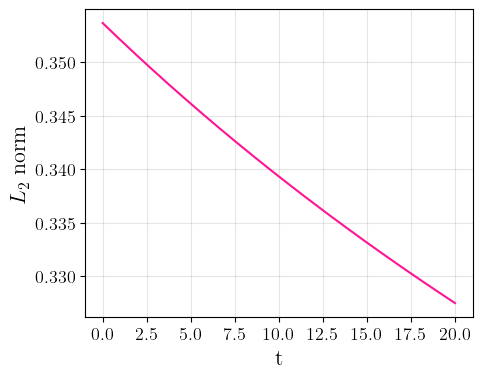

In [398]:
# Plot and save the l2 norm
plt.figure(figsize=(5, 4))
plt.plot(time, l2norm_LaxF, c = 'deeppink')
#plt.title('$L_2$ norm - Lax-Friedrichs ($C_f$ = %.2f, N = %i)' % (cf, nx), fontsize = 17)
plt.xlabel('t', fontsize = 16)
plt.ylabel('$L_2$ norm', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(alpha = 0.2, c = 'grey')
figname = f"./images_LaxF/L2norm_LaxF_c{c_str}_n{n_str}.png"
plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.show()

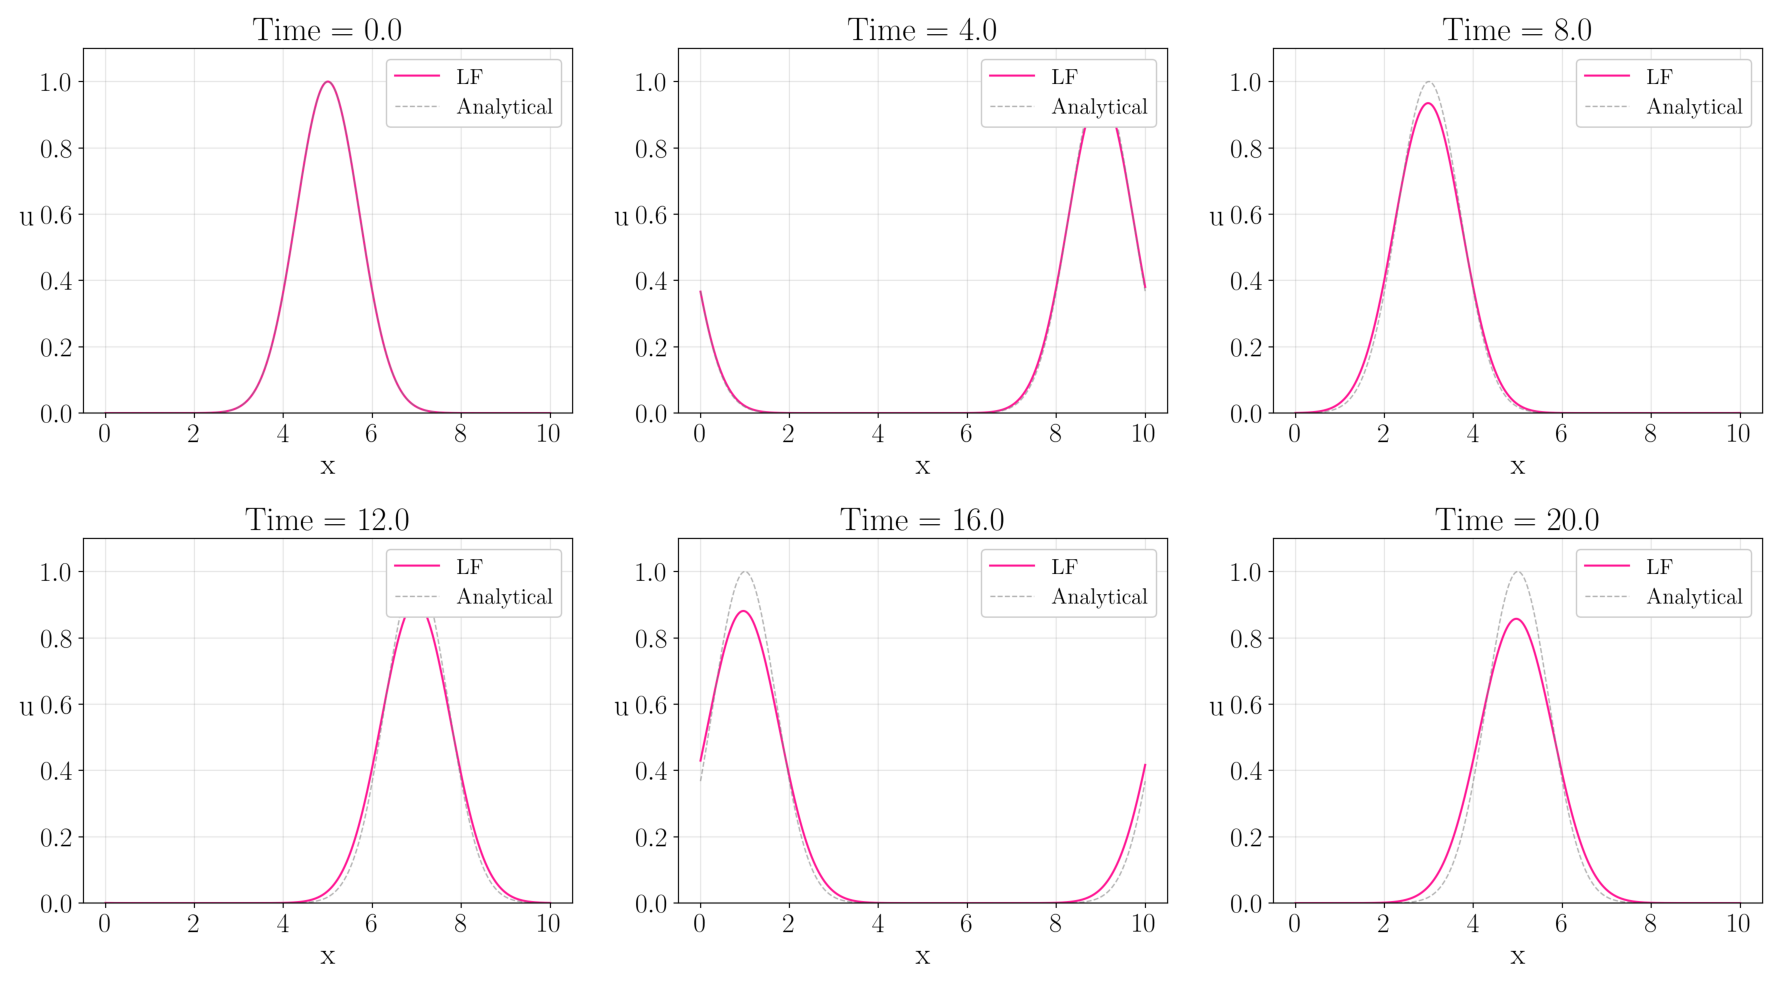

In [399]:
# FOR THE REPORT
filenames = [
    f"./images_LaxF/fig_LaxF_c{c_str}_n{n_str}_t{idx:05d}.png"
    for idx in indices_6
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, fname, idx in zip(axes.flat, filenames, indices_6):
    img = imread(fname)
    ax.imshow(img)
    ax.set_axis_off()

plt.tight_layout()

grid_name = f"./images_LaxF/grid_LaxF_c{c_str}_n{n_str}.png"
plt.savefig(grid_name, dpi=200, bbox_inches='tight')
plt.show()
plt.close()

## Leapfrog

In [400]:
# Initialize the solution array
u_previous = u_initial.copy()     # This will be step zero, u_current will be computed with Lax-Friedrichs

#we create arrays where we will store the time and the l2norm
l2norm_Leap=[]
l2norm_Leap.append(np.sqrt(np.sum(u_previous**2)/len(u_previous)))

time=[]
time.append(0.0)

In [401]:
# Create directory to save images IF there isn't one yet
print(os.getcwd())
if not os.path.exists('./images_Leap'):
    os.makedirs('./images_Leap')
os.listdir('./')

C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation


['.ipynb_checkpoints',
 'Advection equation.ipynb',
 'Advection_equation_movies',
 'images_FTCS',
 'images_LaxF',
 'images_Leap',
 'images_Leap_ex',
 'images_Leap_LF',
 'images_LW']

In [402]:
# Initialize time and iteration counter
t = 0.0
i = 0

#save the initial conditions
# Note: I'm plotting things with a very big fontsize for better visibility in the report
plt.plot(x, u_previous, c = 'mediumspringgreen', label='Leapfrog')
plt.plot(x, u_initial, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
plt.title('Time = '+str(round(t,2)), fontsize = 24)
plt.ylim(-0.1,1.1)
plt.xlabel('x', fontsize = 22)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')

# To save the figure with the courant factor, the number of points on the x axis and the timestamp info
c_str = f"{int(cf * 100):03d}"
n_str = f"{nx:03d}"
i_str = f"{i:05d}"
figname = f"./images_Leap/fig_Leap_c{c_str}_n{n_str}_t{i_str}.png"

plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.close()

# Solve the advection equation
# I need u^(n-1) -> I use Lax-Friedrichs for the first step (u_current):
u_current = 0.5*(np.roll(u_previous, -1) + np.roll(u_previous, 1)) - a*dt/(2*dx)*(np.roll(u_previous, -1) - np.roll(u_previous, 1))
t += dt
i += 1

l2norm_Leap.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
time.append(t)

while t < t_final:
    # Compute the new solution using the Leapfrog method
    u_next = u_previous - a*(dt/dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))

    # Update the solution
    u_previous = u_current.copy()
    u_current = u_next.copy()

    #advance the time 
    t += dt
    i += 1
    
    #compute the l2 norm and add the time to the time vector
    l2norm_Leap.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
    time.append(t)
    
    #plot the current result and save in an image every 10 iterations
    if i in combined:

        x_shift = (x - a*t) % L
        u_analytic = np.exp(-(x_shift - x0)**2)
    
        plt.plot(x, u_current, c='mediumspringgreen', label='Leapfrog')
        plt.plot(x, u_analytic, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
        plt.title('Time = '+str(round(t,2)), fontsize = 24)
        plt.ylim(-0.1,1.1)
        plt.xlabel('x', fontsize = 22)
        plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.grid(alpha = 0.2, c = 'grey')
        plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
        i_str = f"{i:05d}"
        figname = f"./images_Leap/fig_Leap_c{c_str}_n{n_str}_t{i_str}.png"
        plt.savefig(figname, dpi=200, bbox_inches='tight')
        plt.close()

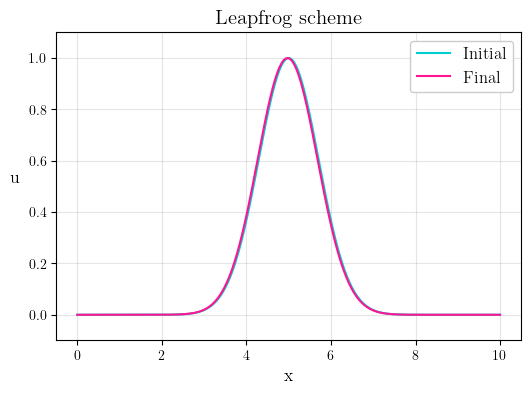

In [403]:
# Plot the final solution
plt.figure(figsize=(6, 4))
plt.plot(x, u_initial, label='Initial', c = 'darkturquoise')
plt.plot(x, u_current, label='Final', c = 'deeppink')
plt.title('Leapfrog scheme', fontsize = 15)
plt.ylim(-0.1,1.1)
plt.xlabel('x', fontsize = 13)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 13)
plt.legend(fontsize = 12, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')
plt.show()

In [404]:
# Check your current working directory
print(os.getcwd())

# Set the directory where the images are stored
directory = "./images_Leap/"

files = os.listdir(directory)
files = sorted(files)
print("\nSorted files:", files)

output_dir = "./Advection_equation_movies/"
os.makedirs(output_dir, exist_ok=True)  # Create if it doesn't exist

c_filter = int(cf*100)
n_filter = nx 

files = sorted(f for f in os.listdir(directory) if f.endswith('.png'))

# Filter files based on Courant factor and number of points
filtered_files = [
    f for f in files
    if f.startswith(f"fig_Leap_c{c_filter:03d}_n{n_filter:03d}_")
]

movie_title = os.path.join(output_dir, f"movie_Leap_c{c_filter:03d}_n{n_filter:03d}.mp4")

# Create the movie
with imageio.get_writer(movie_title, mode='I', quality=10) as writer:
    for file in filtered_files:
        image = imageio.imread(os.path.join(directory, file))
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1160, 975) to (1168, 976) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation

Sorted files: ['L2norm_Leap_c025_n101.png', 'L2norm_Leap_c025_n251.png', 'L2norm_Leap_c025_n501.png', 'L2norm_Leap_c050_n101.png', 'L2norm_Leap_c050_n251.png', 'L2norm_Leap_c050_n501.png', 'L2norm_Leap_c080_n101.png', 'L2norm_Leap_c080_n251.png', 'fig_Leap_c025_n101_t00000.png', 'fig_Leap_c025_n101_t00020.png', 'fig_Leap_c025_n101_t00041.png', 'fig_Leap_c025_n101_t00061.png', 'fig_Leap_c025_n101_t00082.png', 'fig_Leap_c025_n101_t00102.png', 'fig_Leap_c025_n101_t00123.png', 'fig_Leap_c025_n101_t00143.png', 'fig_Leap_c025_n101_t00160.png', 'fig_Leap_c025_n101_t00164.png', 'fig_Leap_c025_n101_t00184.png', 'fig_Leap_c025_n101_t00205.png', 'fig_Leap_c025_n101_t00225.png', 'fig_Leap_c025_n101_t00246.png', 'fig_Leap_c025_n101_t00266.png', 'fig_Leap_c025_n101_t00287.png', 'fig_Leap_c025_n101_t00307.png', 'fig_Leap_c025_n101_t00320.png', 'fig_Leap_c025_n101_t00328.png', 'fig_Leap_c025_n101_t00348.png', 'fig_Leap_c025_n101_t

In [405]:
# Displaying the movie

HTML(f"""
<div align="middle">
  <video width="50%" controls>
    <source src="{movie_title}" type="video/mp4">
  </video>
</div>
""")

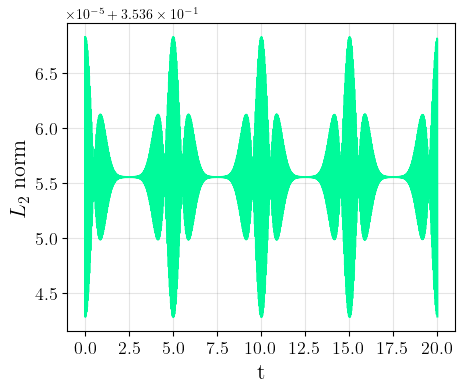

In [406]:
# Plot and save the l2 norm
plt.figure(figsize=(5, 4))
plt.plot(time, l2norm_Leap, c = 'mediumspringgreen')
#plt.title('$L_2$ norm - Leapfrog ($C_f$ = %.2f, N = %i)' % (cf, nx), fontsize = 17)
plt.xlabel('t', fontsize = 16)
plt.ylabel('$L_2$ norm', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(alpha = 0.2, c = 'grey')
figname = f"./images_Leap/L2norm_Leap_c{c_str}_n{n_str}.png"
plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.show()

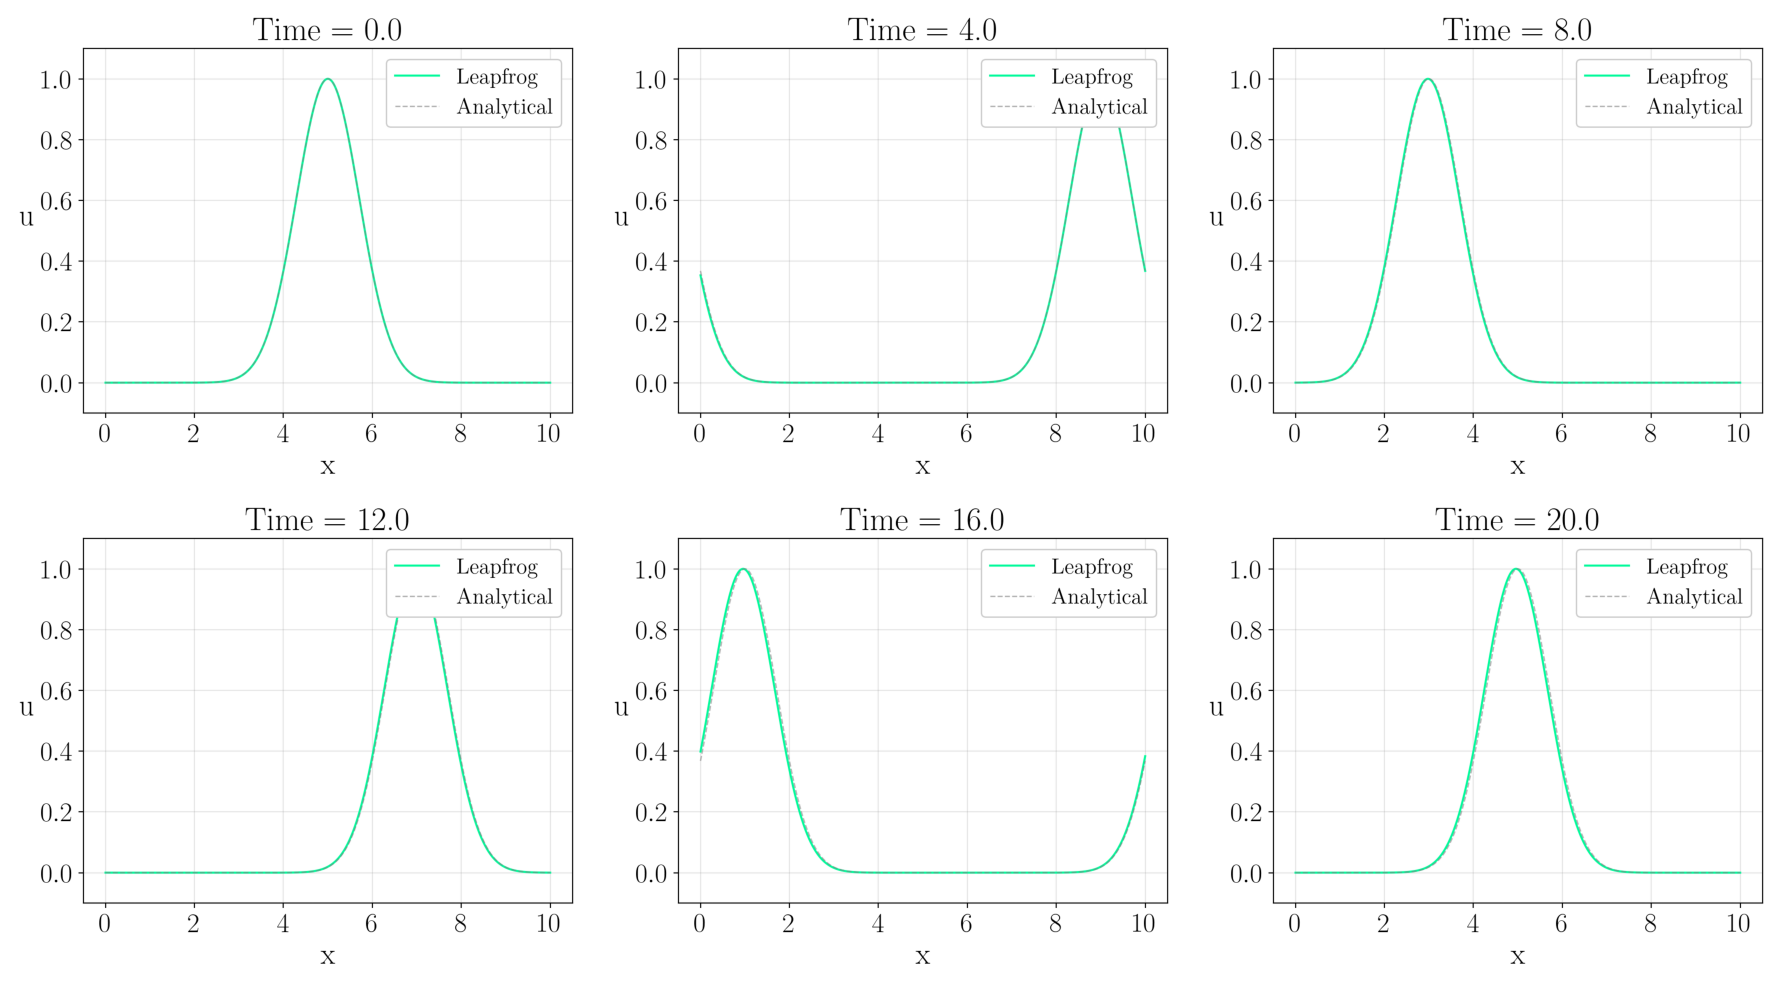

In [407]:
# FOR THE REPORT
filenames = [
    f"./images_Leap/fig_Leap_c{c_str}_n{n_str}_t{idx:05d}.png"
    for idx in indices_6
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, fname, idx in zip(axes.flat, filenames, indices_6):
    img = imread(fname)
    ax.imshow(img)
    ax.set_axis_off()

plt.tight_layout()

grid_name = f"./images_Leap/grid_Leap_c{c_str}_n{n_str}.png"
plt.savefig(grid_name, dpi=200, bbox_inches='tight')
plt.show()
plt.close()

## Lax-Wendroff

In [416]:
# Initialize the solution array
u_current = u_initial.copy()

#we create arrays where we will store the time and the l2norm
l2norm_LW=[]
l2norm_LW.append(np.sqrt(np.sum(u_current**2)/len(u_current)))

time=[]
time.append(0.0)

In [417]:
# Create directory to save images IF there isn't one yet
print(os.getcwd())
if not os.path.exists('./images_LW'):
    os.makedirs('./images_LW')
os.listdir('./')

C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation


['.ipynb_checkpoints',
 'Advection equation.ipynb',
 'Advection_equation_movies',
 'images_FTCS',
 'images_LaxF',
 'images_Leap',
 'images_Leap_ex',
 'images_Leap_LF',
 'images_LW']

In [418]:
# Initialize time and iteration counter
t = 0.0
i = 0

#save the initial conditions
# Note: I'm plotting things with a very big fontsize for better visibility in the report
plt.plot(x, u_current, c = 'darkorange', label='Lax-Wendroff')
plt.plot(x, u_initial, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
plt.title('Time = '+str(round(t,2)), fontsize = 24)
plt.ylim(-0.1,1.1)
plt.xlabel('x', fontsize = 22)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')

# To save the figure with the courant factor, the number of points on the x axis and the timestamp info
c_str = f"{int(cf * 100):03d}"
n_str = f"{nx:03d}"
i_str = f"{i:05d}"
figname = f"./images_LW/fig_LW_c{c_str}_n{n_str}_t{i_str}.png"

plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.close()

#solve the advection equation
while t < t_final:
    # Compute the new solution using the Lax-Wendroff method
    u_next = u_current - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1)) + ((a*dt)**2)/(2*(dx)**2)*(np.roll(u_current, -1) - 2*u_current + np.roll(u_current, 1))
    
    # Update the solution
    u_current = u_next.copy()

    #advance the time 
    t += dt
    i += 1
    
    #compute the l2 norm and add the time to the time vector
    l2norm_LW.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
    time.append(t)
    
    #plot the current result and save in an image every 10 iterations
    if i in combined:

        x_shift = (x - a*t) % L
        u_analytic = np.exp(-(x_shift - x0)**2)
    
        plt.plot(x, u_current, c='darkorange', label='Lax-Wendroff')
        plt.plot(x, u_analytic, c='grey', lw=1, alpha=0.6, ls = '--', label='Analytical')
        plt.title('Time = '+str(round(t,2)), fontsize = 24)
        plt.ylim(-0.1,1.1)
        plt.xlabel('x', fontsize = 22)
        plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 22)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.grid(alpha = 0.2, c = 'grey')
        plt.legend(loc='upper right', fontsize = 16, framealpha = 1)
        i_str = f"{i:05d}"
        figname = f"./images_LW/fig_LW_c{c_str}_n{n_str}_t{i_str}.png"
        plt.savefig(figname, dpi=200, bbox_inches='tight')
        plt.close()

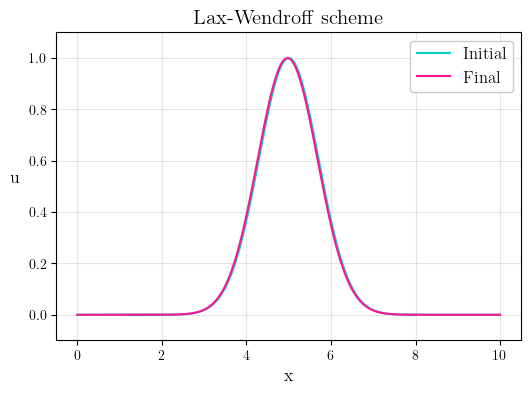

In [419]:
# Plot the final solution
plt.figure(figsize=(6, 4))
plt.plot(x, u_initial, label='Initial', c = 'darkturquoise')
plt.plot(x, u_current, label='Final', c = 'deeppink')
plt.title('Lax-Wendroff scheme', fontsize = 15)
#plt.title('Time='+str(round(t,2)), fontsize = 15)
plt.ylim(-0.1,1.1)
plt.xlabel('x', fontsize = 13)
plt.ylabel('u', rotation = 0, labelpad = 10, fontsize = 13)
plt.legend(fontsize = 12, framealpha = 1)
plt.grid(alpha = 0.2, c = 'grey')
plt.show()

In [420]:
# Check your current working directory
print(os.getcwd())

# Set the directory where the images are stored
directory = "./images_LW/"

files = os.listdir(directory)
files = sorted(files)
print("\nSorted files:", files)

output_dir = "./Advection_equation_movies/"
os.makedirs(output_dir, exist_ok=True)  # Create if it doesn't exist

c_filter = int(cf*100)
n_filter = nx 

files = sorted(f for f in os.listdir(directory) if f.endswith('.png'))

# Filter files based on Courant factor and number of points
filtered_files = [
    f for f in files
    if f.startswith(f"fig_LW_c{c_filter:03d}_n{n_filter:03d}_")
]

movie_title = os.path.join(output_dir, f"movie_LW_c{c_filter:03d}_n{n_filter:03d}.mp4")

# Create the movie
with imageio.get_writer(movie_title, mode='I', quality=10) as writer:
    for file in filtered_files:
        image = imageio.imread(os.path.join(directory, file))
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1160, 975) to (1168, 976) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


C:\Users\lilit\reps\Numerical_relativity\Homework_1\Advection equation

Sorted files: ['.ipynb_checkpoints', 'L2norm_LW_c025_n101.png', 'L2norm_LW_c025_n251.png', 'L2norm_LW_c025_n501.png', 'L2norm_LW_c050_n101.png', 'L2norm_LW_c050_n251.png', 'L2norm_LW_c050_n501.png', 'L2norm_LW_c080_n101.png', 'L2norm_LW_c080_n251.png', 'L2norm_LW_c080_n501.png', 'fig_LW_c025_n101_t00000.png', 'fig_LW_c025_n101_t00020.png', 'fig_LW_c025_n101_t00041.png', 'fig_LW_c025_n101_t00061.png', 'fig_LW_c025_n101_t00082.png', 'fig_LW_c025_n101_t00102.png', 'fig_LW_c025_n101_t00123.png', 'fig_LW_c025_n101_t00143.png', 'fig_LW_c025_n101_t00160.png', 'fig_LW_c025_n101_t00164.png', 'fig_LW_c025_n101_t00184.png', 'fig_LW_c025_n101_t00205.png', 'fig_LW_c025_n101_t00225.png', 'fig_LW_c025_n101_t00246.png', 'fig_LW_c025_n101_t00266.png', 'fig_LW_c025_n101_t00287.png', 'fig_LW_c025_n101_t00307.png', 'fig_LW_c025_n101_t00320.png', 'fig_LW_c025_n101_t00328.png', 'fig_LW_c025_n101_t00348.png', 'fig_LW_c025_n101_t00369.png

In [421]:
# Displaying the movie

HTML(f"""
<div align="middle">
  <video width="50%" controls>
    <source src="{movie_title}" type="video/mp4">
  </video>
</div>
""")

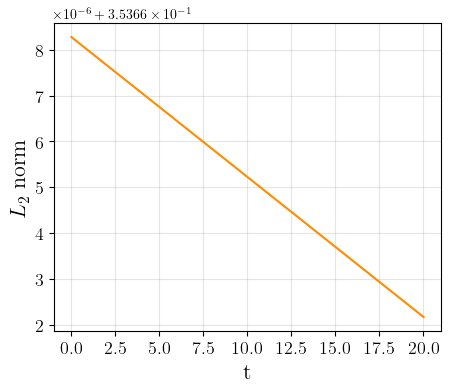

In [422]:
# Plot and save the l2 norm
plt.figure(figsize=(5, 4))
plt.plot(time, l2norm_LW, c = 'darkorange')
#plt.title('$L_2$ norm - Lax-Wendroff ($C_f$ = %.2f, N = %i)' % (cf, nx), fontsize = 17)
plt.xlabel('t', fontsize = 16)
plt.ylabel('$L_2$ norm', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(alpha = 0.2, c = 'grey')
figname = f"./images_LW/L2norm_LW_c{c_str}_n{n_str}.png"
plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.show()

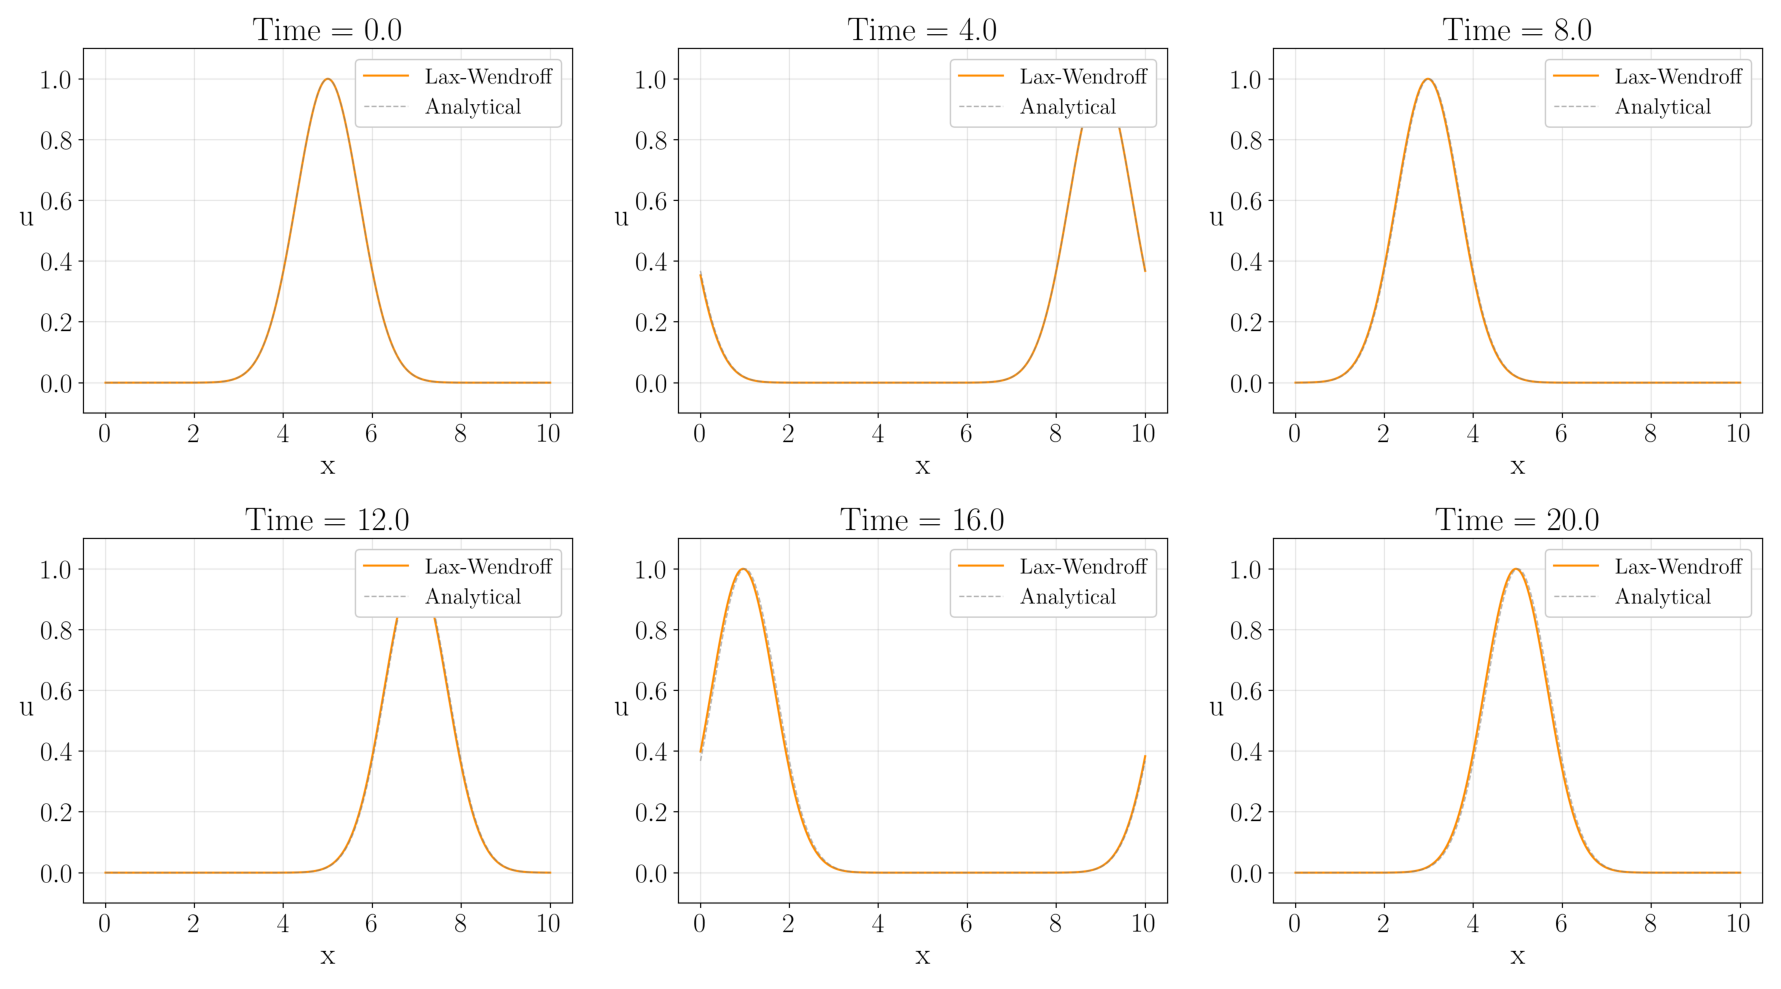

In [423]:
# FOR THE REPORT

filenames = [
    f"./images_LW/fig_LW_c{c_str}_n{n_str}_t{idx:05d}.png"
    for idx in indices_6
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, fname, idx in zip(axes.flat, filenames, indices_6):
    img = imread(fname)
    ax.imshow(img)
    ax.set_axis_off()

plt.tight_layout()

grid_name = f"./images_LW/grid_LW_c{c_str}_n{n_str}.png"
plt.savefig(grid_name, dpi=200, bbox_inches='tight')
plt.show()
plt.close()